# You're Not A-Loan

Our tool leverages machine learning models to aid lenders in making informed decisions, ensuring borrowers achieve their goals without encountering financial strain. By assessing borrowing capacity, we mitigate risks and facilitate successful lending outcomes.

In [59]:
# Import the modules
import numpy as np
import pandas as pd
import xgboost as xgb
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

---

## Reading 'lending_data.csv' Data from the 'Resources' Folder into a Pandas DataFrame

In [60]:
# Read the CSV file from the 'Resources' folder into a Pandas DataFrame
test_loan_df = pd.read_csv(Path("Resources/test-loan defaulter data.csv"))

# Review the DataFrame
test_loan_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [61]:
test_loan_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [62]:
test_loan_df.shape

(614, 13)

In [63]:
test_loan_df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [64]:
test_loan_df['Property_Area'].value_counts()

Property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64

In [9]:
test_loan_df['Credit_History'].value_counts()

Credit_History
1.0    475
0.0     89
Name: count, dtype: int64

In [10]:
test_loan_df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [11]:
# Fill the missing values for numerical terms - mean
test_loan_df['LoanAmount'] = test_loan_df['LoanAmount'].fillna(test_loan_df['LoanAmount'].mean())
test_loan_df['Loan_Amount_Term'] = test_loan_df['Loan_Amount_Term'].fillna(test_loan_df['Loan_Amount_Term'].mean())
test_loan_df['Credit_History'] = test_loan_df['Credit_History'].fillna(test_loan_df['Credit_History'].mean())

In [12]:
# Fill the missing values for categorical terms - mode
test_loan_df['Gender'] = test_loan_df["Gender"].fillna(test_loan_df['Gender'].mode()[0])
test_loan_df['Married'] = test_loan_df["Married"].fillna(test_loan_df['Married'].mode()[0])
test_loan_df['Dependents'] = test_loan_df["Dependents"].fillna(test_loan_df['Dependents'].mode()[0])
test_loan_df['Self_Employed'] = test_loan_df["Self_Employed"].fillna(test_loan_df['Self_Employed'].mode()[0])

In [13]:
test_loan_df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [14]:
test_loan_df.duplicated().sum()

0

In [15]:
test_loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


## Exploratory Data Analysis

<Axes: xlabel='Gender', ylabel='count'>

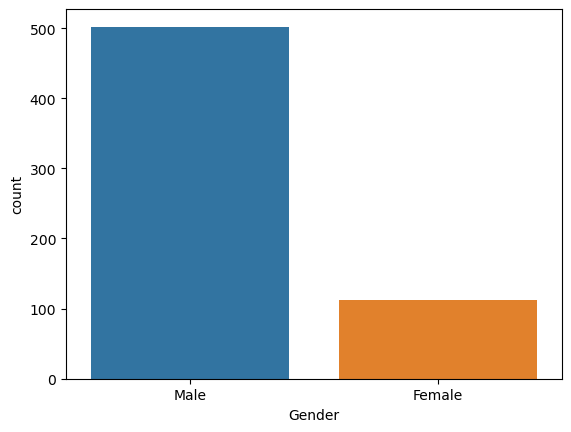

In [22]:
# Visualization of Categorical Attributes
sns.countplot(x ='Gender', data = test_loan_df)

<Axes: xlabel='Married', ylabel='count'>

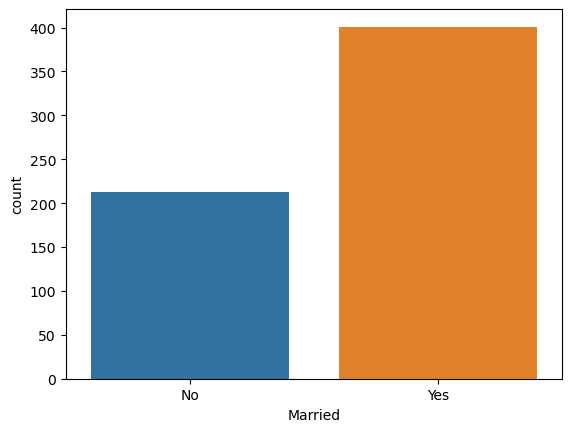

In [23]:
sns.countplot(x ='Married', data = test_loan_df)

<Axes: xlabel='Dependents', ylabel='count'>

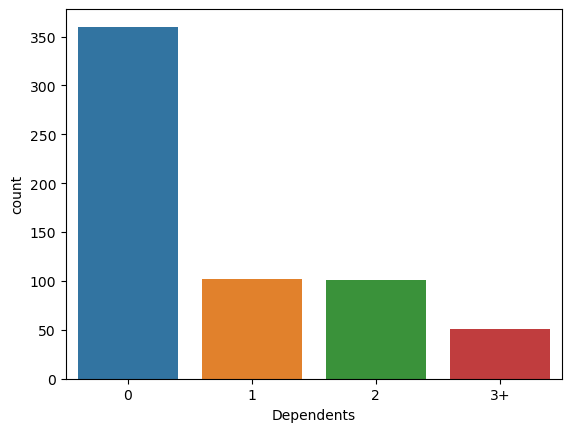

In [24]:
sns.countplot(x ='Dependents', data = test_loan_df)

<Axes: xlabel='Education', ylabel='count'>

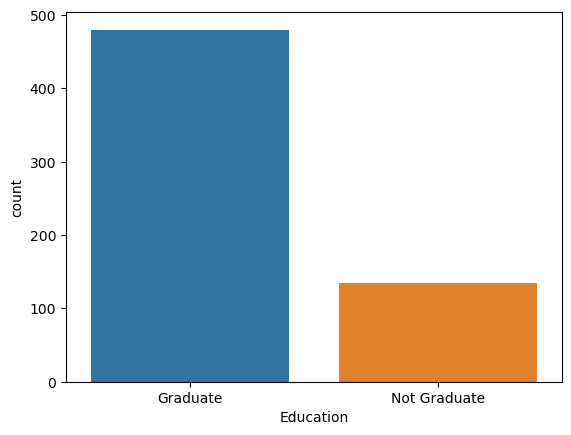

In [25]:
sns.countplot(x ='Education', data = test_loan_df)

<Axes: xlabel='Self_Employed', ylabel='count'>

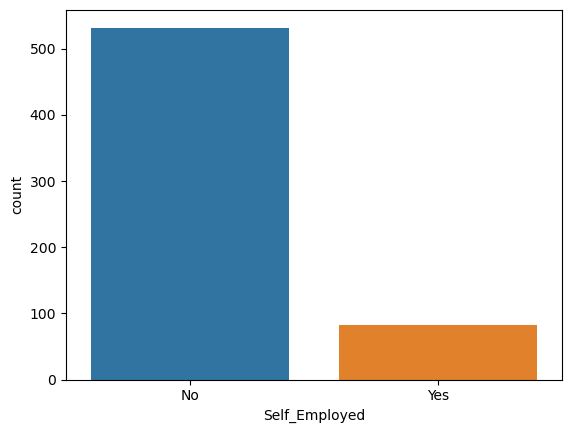

In [26]:
sns.countplot(x ='Self_Employed', data = test_loan_df)

<Axes: xlabel='Property_Area', ylabel='count'>

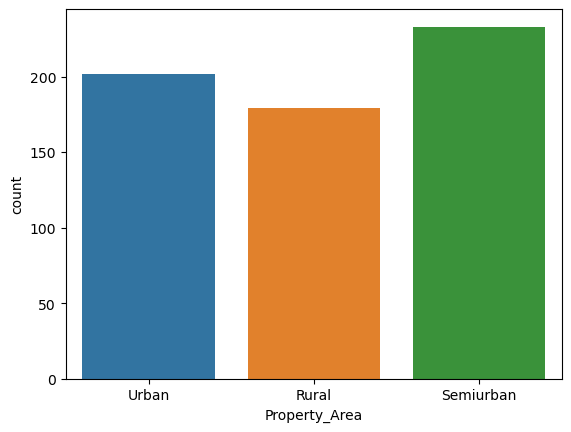

In [27]:
sns.countplot(x ='Property_Area', data = test_loan_df)

<Axes: xlabel='Loan_Status', ylabel='count'>

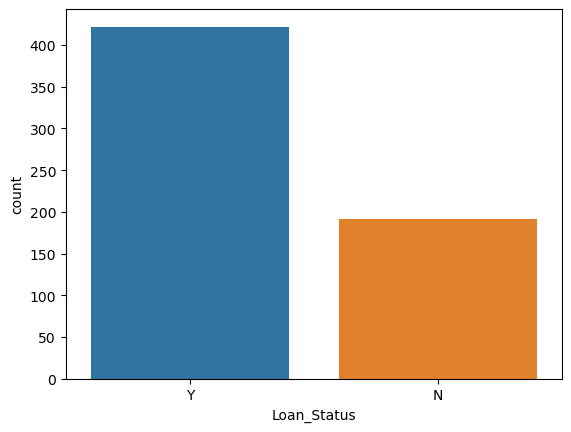

In [28]:
sns.countplot(x ='Loan_Status', data = test_loan_df)

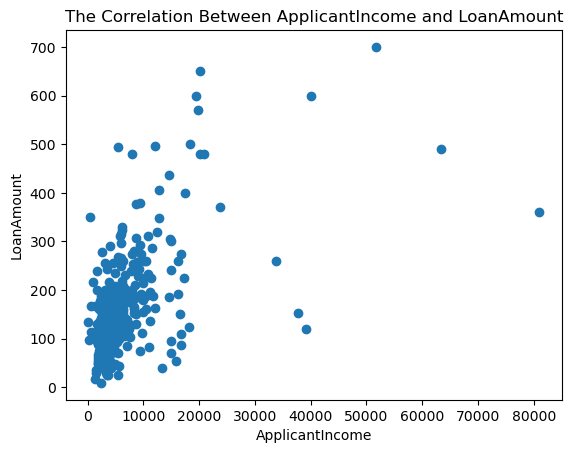

In [65]:
# Correlation between Applicant Income and Loan Amount
 
plt.scatter(x='ApplicantIncome',y='LoanAmount',data=test_loan_df)
plt.xlabel('ApplicantIncome')
plt.ylabel('LoanAmount')
plt.title('The Correlation Between ApplicantIncome and LoanAmount')
plt.show()

## Creation of New Attributes

In [30]:
# Total Income
test_loan_df['Total_Income'] = test_loan_df['ApplicantIncome'] + test_loan_df['CoapplicantIncome']
test_loan_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,5849.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,6091.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,3000.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4941.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,6000.0


## Label Encoding

In [31]:
# Label Encode the Target Variable
encode = LabelEncoder()
test_loan_df.Loan_Status = encode.fit_transform(test_loan_df.Loan_Status)

In [33]:
# Ordinal Encode the Features
enc = OrdinalEncoder() 
test_loan_df[["Gender",'Married','Education','Self_Employed','Property_Area','Loan_Status', 'Dependents']] = enc.fit_transform(test_loan_df[["Gender",'Married','Education','Self_Employed','Property_Area','Loan_Status', 'Dependents']])
test_loan_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP001002,1.0,0.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1.0,5849.0
1,LP001003,1.0,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0.0,6091.0
2,LP001005,1.0,1.0,0.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1.0,3000.0
3,LP001006,1.0,1.0,0.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1.0,4941.0
4,LP001008,1.0,0.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1.0,6000.0


The dataset's values are all now presented as numbers. It will make training our model easier for us.
For Loan status 1 indicates 'Yes'or 'Approved' and 0 indicates 'No' or 'Rejected'.

## Splitting into Dependent and Independent Variables (Target and Features)

In [34]:
# Specify Input and Output Attributes
X = test_loan_df.drop(columns=['Loan_ID','Loan_Status'], axis=1)
y = test_loan_df['Loan_Status']

In [35]:
# Review the Series of the y Variable
y[:5]

0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: Loan_Status, dtype: float64

## Checking Label Variable (y) Balance Using the value_counts Function

In [36]:
# Checking the Balance of Our Target Values
y.value_counts()

Loan_Status
1.0    422
0.0    192
Name: count, dtype: int64

## Splitting Data into Training and Testing Datasets Using train_test_split

In [37]:
# Import the train_test_learn module
from sklearn.model_selection import train_test_split

# Splitting the Data Using train_test_split
# Assigning a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [38]:
def classification_metrics(y_true, y_pred, class_labels=None):
    """
    Display the classification report and confusion matrix.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        class_labels (list, optional): List of class labels for display. If not provided, it will be inferred.

    Returns:
        None
    """
    if class_labels is None:
        class_labels = sorted(set(y_true))  # Inferring Class Labels from y_true

    # Mapping Binary Labels to Meaningful Labels
    class_labels = ["Loan Repaid", "Defaulted on Loan"]

    # Printing the Classification Report
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print("Classification Report:\n", report)
    
    # Computing the Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Creating a Heatmap for the Confusion Matrix
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=class_labels, yticklabels=class_labels)
    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    
    plt.show()

In [39]:
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier

    predictors: independent variables

    target: dependent variable
    """

    # Predicting Using the Independent Variables
    pred = model.predict(predictors)

    precision = round(precision_score(target, pred, average='macro'), 2)     # Precision score
    recall = round(recall_score(target, pred, average='macro'), 2)           # Recall score
    accuracy = round(accuracy_score(target, pred), 2)                        # Accuracy score

    # Creating a Dictionary of Metrics
    metrics_dict = {
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
    }

    return metrics_dict

In [40]:
# Importing the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiating the Logistic Regression model
# Assigning a random_state parameter of 1 to the model
logistic_regression_model = LogisticRegression(random_state = 1)

# Fitting the model using training data
logistic_regression_model.fit(X_train, y_train)

LogisticRegression(random_state=1)

# Creating a Logistic Regression Model with the Original Data

## Making Predictions Using Training Data

Classification Report:
                    precision    recall  f1-score   support

      Loan Repaid       0.92      0.45      0.61       143
Defaulted on Loan       0.80      0.98      0.88       317

         accuracy                           0.82       460
        macro avg       0.86      0.72      0.74       460
     weighted avg       0.84      0.82      0.80       460



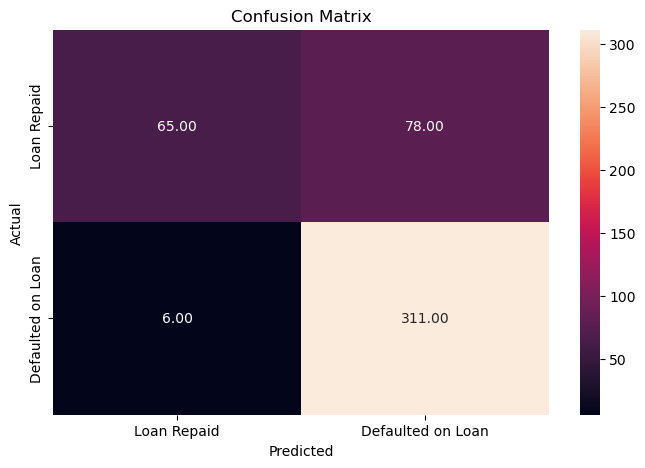

In [41]:
# Predicting on the Training Set
y_train_pred_log_reg = logistic_regression_model.predict(X_train)

# Evaluating the Performance on the Training Set
classification_metrics(y_train, y_train_pred_log_reg)

Based on the classification report for a logistic regression model, we observe an overall accuracy of 82%.

For the "Loan Repaid" class, the precision is 0.92, recall is 0.45, and F1-score is 0.61. This indicates that when the model predicts a loan will be repaid, it is correct 92% of the time. However, it only correctly identifies 45% of the actual instances where the loan was repaid.

For the "Defaulted on Loan" class, the precision is 0.80, recall is 0.98, and F1-score is 0.88. This suggests that when the model predicts a loan will be defaulted on, it is correct 80% of the time. It also correctly identifies 98% of the actual instances where the loan was defaulted on.

Overall, the model performs better in predicting the "Defaulted on Loan" class compared to the "Loan Repaid" class. This could be due to an imbalance in the dataset or the features used in the model. Further analysis and fine-tuning of the model may be necessary to improve its performance.

## Making Predictions Using Testing Data

Classification Report:
                    precision    recall  f1-score   support

      Loan Repaid       0.86      0.39      0.54        49
Defaulted on Loan       0.77      0.97      0.86       105

         accuracy                           0.79       154
        macro avg       0.82      0.68      0.70       154
     weighted avg       0.80      0.79      0.76       154



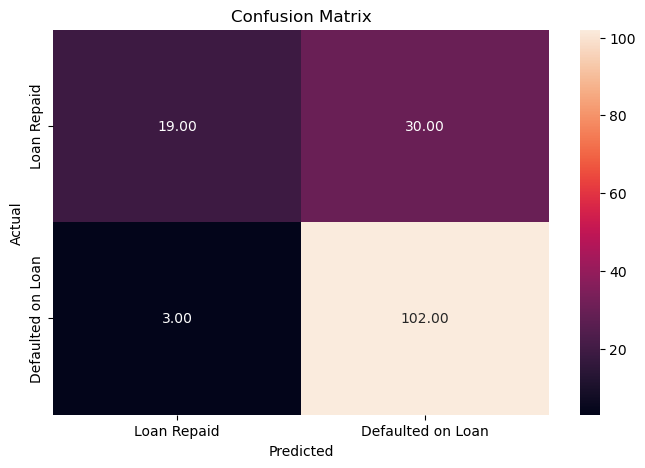

In [42]:
# Predicting on the Test Set
y_prediction = logistic_regression_model.predict(X_test)

# Evaluating the Performance on the Test Set
classification_metrics(y_test, y_prediction)

Based on the provided classification report from a logistic regression model:

* Precision for the “Loan Repaid” class is 0.86, indicating that when the model predicts a loan to be repaid, it is correct 86% of the time.
* Recall for the “Loan Repaid” class is 0.39, indicating that the model correctly identifies 39% of the actual instances of loans being repaid.
* The F1-score for the “Loan Repaid” class is 0.54, representing the harmonic mean of precision and recall, balancing both metrics.
* Precision for the “Defaulted on Loan” class is 0.77, meaning when the model predicts a loan to be defaulted, it is correct 77% of the time.
* Recall for the “Defaulted on Loan” class is 0.97, indicating that the model correctly identifies 97% of the actual instances of defaulted loans.
* The F1-score for the “Defaulted on Loan” class is 0.86, representing the balance between precision and recall for this class.

Overall, the model achieves an accuracy of 79%, with a macro average F1-score of 0.70 and a weighted average F1-score of 0.76. The macro average considers the unweighted mean of precision, recall, and F1-score across both classes, while the weighted average considers the average weighted by support (the number of true instances for each class).

## Evaluating Model Performance: Accuracy Score, Confusion Matrix, and Classification Report

In [43]:
# Printing the Balanced Accuracy Score of the Model
balanced_accuracy_score(y_test, y_prediction)

0.6795918367346938

## Confusion Matrix

In [44]:
# Generating a Confusion Matrix for the Model
confusion_matrix(y_test, y_prediction)

array([[ 19,  30],
       [  3, 102]])

This confusion matrix indicates the following:

* True Negative (TN): 19
* False Positive (FP): 30
* False Negative (FN): 3
* True Positive (TP): 102

In the context of a binary classification problem:

* TN: The number of correctly predicted instances of the negative class (Loan Repaid in this case).
* FP: The number of incorrectly predicted instances of the positive class (False alarms of Loan Default).
* FN: The number of instances of the negative class incorrectly predicted as positive (Missed opportunities of Loan Repaid).
* TP: The number of correctly predicted instances of the positive class (Defaulted on Loan).

From this confusion matrix, we can observe that the model:

* Correctly predicted 19 instances of Loan Repaid (TN).
* Incorrectly predicted 30 instances as Defaulted on Loan when they were actually Loan Repaid (FP).
* Missed predicting 3 instances of Loan Repaid as Loan Repaid (FN).
* Correctly predicted 102 instances of Defaulted on Loan (TP).

In [45]:
# Printing the Classification Report for the Model
print(classification_report_imbalanced(y_test, y_prediction))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.86      0.39      0.97      0.54      0.61      0.35        49
        1.0       0.77      0.97      0.39      0.86      0.61      0.40       105

avg / total       0.80      0.79      0.57      0.76      0.61      0.38       154



Analyzing the classification report with imbalanced classes:

* Precision (pre):

    * For class 0.0 (Loan Repaid), precision is 0.86, indicating that when the model predicts a loan to be repaid, it is correct 86% of the time.
    * For class 1.0 (Defaulted on Loan), precision is 0.77, meaning that when the model predicts a loan to be defaulted, it is correct 77% of the time.

* Recall (rec):

    * For class 0.0, recall is 0.39, indicating that the model correctly identifies only 39% of the actual instances of loans being repaid.
    * For class 1.0, recall is 0.97, meaning the model correctly identifies 97% of the actual instances of defaulted loans.

* Specificity (spe):

    * For class 0.0, specificity is 0.97, indicating the proportion of actual negative cases that were correctly identified as negative.
    * For class 1.0, specificity is 0.39, indicating the proportion of actual positive cases that were correctly identified as positive.

* F1-score (f1):

    * For class 0.0, the F1-score is 0.54, providing a balance between precision and recall for this class.
    * For class 1.0, the F1-score is 0.86, representing the balance between precision and recall for this class.

* Geometric Mean (geo):

    * Geo is a measure of the central tendency or typical value of a set of numbers. In this context, it’s used as a measure of balanced performance between precision and recall.

* Index of Balanced Accuracy (iba):

    * Iba measures the extent of agreement between the observed and predicted classes, providing insight into the model’s balanced accuracy.

* Support (sup):

    * The number of actual occurrences of each class in the dataset.

Overall, the classification report provides detailed insights into the model’s performance, especially in handling imbalanced classes, with metrics like precision, recall, specificity, F1-score, geometric mean, and index of balanced accuracy.

## Predicting with a Logistic Regression Model Using Resampled Training Data

 Using the RandomOverSampler module from the imbalanced-learn library to resample the data. Be sure to confirm that the labels have an equal number of data points.

In [46]:
# Importing the RandomOverSampler module from imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# Instantiating the Random Oversampler Model
# Assigning a random_state parameter of 1 to the model
random_oversampler = RandomOverSampler(random_state=1)

# Fitting the original training data to the Random Oversampler model
X_resampled, y_resampled = random_oversampler.fit_resample(X_train, y_train)

In [47]:
# Count the distinct values of the resampled labels data
y_resampled.value_counts()

Loan_Status
1.0    317
0.0    317
Name: count, dtype: int64

## Fitting Logistic Regression Model and Making Predictions Using Resampled Data

In [48]:
# Instantiating the Logistic Regression Model
# Assigning a random_state parameter of 1 to the model
model = LogisticRegression(random_state=1)

# Fitting the model using the resampled training data
model.fit(X_resampled, y_resampled)
# Making Predictions Using Testing Data
y_pred = model.predict(X_test)

## Evaluating Model Performance: Accuracy Score, Confusion Matrix, and Classification Report with Resampled Data

In [49]:
# Printing the Balanced Accuracy Score of the Model 
balanced_accuracy_score(y_test, y_pred)

0.6789115646258503

## Confusion Matrix

In [50]:
# Generating a Confusion Matrix for the Model
confusion_matrix(y_test, y_pred)

array([[25, 24],
       [16, 89]])

This confusion matrix indicates the following:

* True Negative (TN): 25
* False Positive (FP): 24
* False Negative (FN): 16
* True Positive (TP): 89

In the context of a binary classification problem:

* TN: The number of correctly predicted instances of the negative class (Loan Repaid in this case).
* FP: The number of incorrectly predicted instances of the positive class (False alarms of Loan Default).
* FN: The number of instances of the negative class incorrectly predicted as positive (Missed opportunities of Loan Repaid).
* TP: The number of correctly predicted instances of the positive class (Defaulted on Loan).

From this confusion matrix, we can observe that the model:

* Correctly predicted 25 instances of Loan Repaid (TN).
* Incorrectly predicted 24 instances as Defaulted on Loan when they were actually Loan Repaid (FP).
* Missed predicting 16 instances of Loan Repaid as Loan Repaid (FN).
* Correctly predicted 89 instances of Defaulted on Loan (TP).

In [42]:
# Printing the Classification Report for the Model
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.61      0.51      0.85      0.56      0.66      0.42        49
        1.0       0.79      0.85      0.51      0.82      0.66      0.45       105

avg / total       0.73      0.74      0.62      0.73      0.66      0.44       154



---

## Decision Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier
# Building the Model
decision_tree = DecisionTreeClassifier(criterion = 'gini', max_depth=3)

# Fitting the Decision Tree Model
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

Classification Report:
                    precision    recall  f1-score   support

      Loan Repaid       0.86      0.39      0.54        49
Defaulted on Loan       0.77      0.97      0.86       105

         accuracy                           0.79       154
        macro avg       0.82      0.68      0.70       154
     weighted avg       0.80      0.79      0.76       154



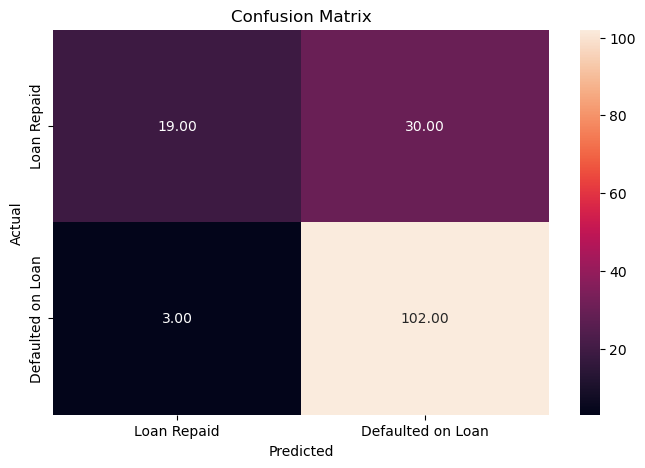

In [52]:
# Checking Performance on the Test Dataset
y_test_pred_decision_tree = decision_tree.predict(X_test)

classification_metrics(y_test, y_test_pred_decision_tree)

The decision tree model’s performance can be analyzed based on the provided classification report:

* Precision for the “Loan Repaid” class is 0.86, indicating that when the model predicts a loan to be repaid, it is correct 86% of the time.
* Recall for the “Loan Repaid” class is 0.39, meaning the model correctly identifies only 39% of the actual instances of loans being repaid.
* The F1-score for the “Loan Repaid” class is 0.54, which is the harmonic mean of precision and recall, balancing both metrics.
* Precision for the “Defaulted on Loan” class is 0.77, indicating that when the model predicts a loan to be defaulted, it is correct 77% of the time.
* Recall for the “Defaulted on Loan” class is 0.97, meaning the model correctly identifies 97% of the actual instances of defaulted loans.
* The F1-score for the “Defaulted on Loan” class is 0.86, representing the balance between precision and recall for this class.

Overall, the model’s accuracy is 79%, with a macro average F1-score of 0.70 and a weighted average F1-score of 0.76. These metrics provide insights into the decision tree model’s performance in predicting loan repayment status.

## Random Forest

In [53]:
# Fitting the Random Forest Classifier on the Training Data
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth = 100,n_estimators = 500, random_state = 1)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, n_estimators=500, random_state=1)

Classification Report:
                    precision    recall  f1-score   support

      Loan Repaid       0.79      0.45      0.57        49
Defaulted on Loan       0.79      0.94      0.86       105

         accuracy                           0.79       154
        macro avg       0.79      0.70      0.71       154
     weighted avg       0.79      0.79      0.77       154



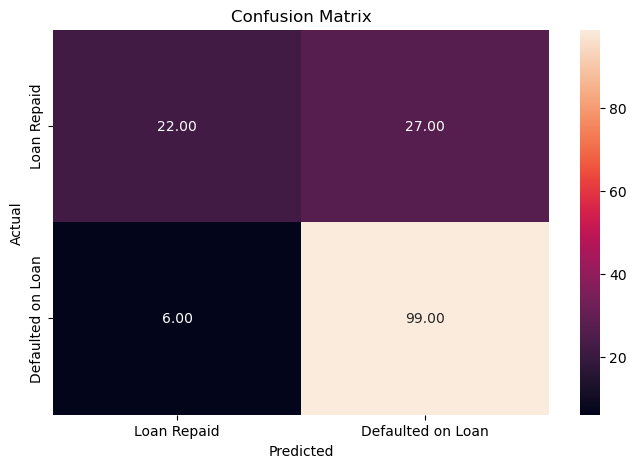

In [54]:
# Checking Performance on the Testing Data
y_pred_test_rf = rf_model.predict(X_test)

classification_metrics(y_test, y_pred_test_rf)

Analyzing the performance of the Random Forest classifier based on the provided classification report:

* Precision for the “Loan Repaid” class is 0.79, indicating that when the model predicts a loan to be repaid, it is correct 79% of the time.
* Recall for the “Loan Repaid” class is 0.45, meaning the model correctly identifies only 45% of the actual instances of loans being repaid.
* The F1-score for the “Loan Repaid” class is 0.57, which is the harmonic mean of precision and recall, providing a balance between the two metrics.
* Precision for the “Defaulted on Loan” class is 0.79, indicating that when the model predicts a loan to be defaulted, it is correct 79% of the time.
* Recall for the “Defaulted on Loan” class is 0.94, meaning the model correctly identifies 94% of the actual instances of defaulted loans.
* The F1-score for the “Defaulted on Loan” class is 0.86, representing the balance between precision and recall for this class.

Overall, the model’s accuracy is 79%, with a macro average F1-score of 0.71 and a weighted average F1-score of 0.77. These metrics provide insights into the Random Forest classifier’s performance in predicting loan repayment status, showcasing comparable results to the logistic regression and decision tree models.

The Random Forest model demonstrates good generalization performance on the test data.

## Naive Bayes

Classification Report:
                    precision    recall  f1-score   support

      Loan Repaid       0.78      0.43      0.55        49
Defaulted on Loan       0.78      0.94      0.85       105

         accuracy                           0.78       154
        macro avg       0.78      0.69      0.70       154
     weighted avg       0.78      0.78      0.76       154



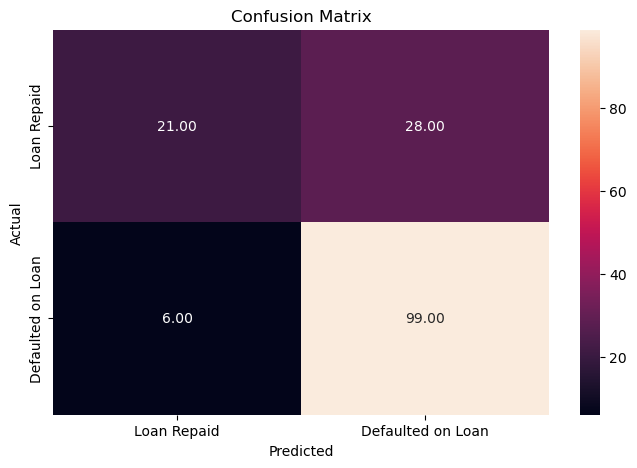

In [55]:
# Using Naive Bayes Model
from sklearn.naive_bayes import GaussianNB
naive_model = GaussianNB()
naive_model.fit(X_train,y_train)
model_predict = naive_model.predict(X_test)
classification_metrics(y_test, model_predict)

Analyzing the performance of the Naive Bayes model based on the provided classification report:

* Precision for the “Loan Repaid” class is 0.78, indicating that when the model predicts a loan to be repaid, it is correct 78% of the time.
* Recall for the “Loan Repaid” class is 0.43, meaning the model correctly identifies only 43% of the actual instances of loans being repaid.
* The F1-score for the “Loan Repaid” class is 0.55, which is the harmonic mean of precision and recall, providing a balance between the two metrics.
* Precision for the “Defaulted on Loan” class is 0.78, indicating that when the model predicts a loan to be defaulted, it is correct 78% of the time.
* Recall for the “Defaulted on Loan” class is 0.94, meaning the model correctly identifies 94% of the actual instances of defaulted loans.
* The F1-score for the “Defaulted on Loan” class is 0.85, representing the balance between precision and recall for this class.

Overall, the model’s accuracy is 78%, with a macro average F1-score of 0.70 and a weighted average F1-score of 0.76. These metrics provide insights into the Naive Bayes model’s performance in predicting loan repayment status, indicating similar performance to the logistic regression, decision tree, and Random Forest classifiers.

## Gradient Boosting

Classification Report:
                    precision    recall  f1-score   support

      Loan Repaid       0.73      0.49      0.59        49
Defaulted on Loan       0.79      0.91      0.85       105

         accuracy                           0.78       154
        macro avg       0.76      0.70      0.72       154
     weighted avg       0.77      0.78      0.77       154



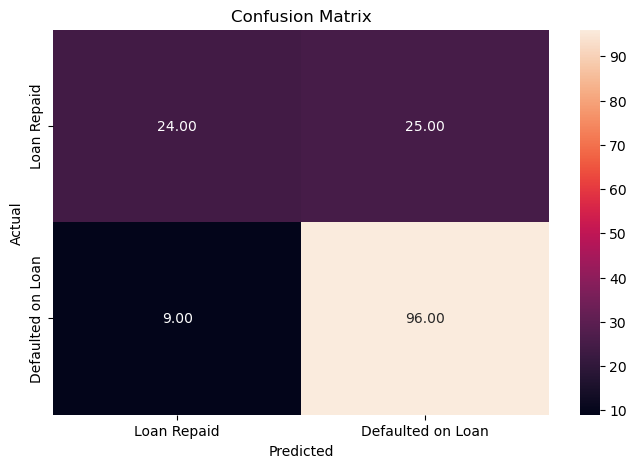

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
gboost_clf = GradientBoostingClassifier(n_estimators=500,max_depth=10)
gboost_clf.fit(X_train,y_train)
gboost_pred = gboost_clf.predict(X_test)
classification_metrics(y_test, gboost_pred)

Analyzing the performance of the Gradient Boosting model based on the provided classification report:

* Precision for the “Loan Repaid” class is 0.64, indicating that when the model predicts a loan to be repaid, it is correct 64% of the time.
* Recall for the “Loan Repaid” class is 0.47, meaning the model correctly identifies only 47% of the actual instances of loans being repaid.
* The F1-score for the “Loan Repaid” class is 0.54, which is the harmonic mean of precision and recall, providing a balance between the two metrics.
* Precision for the “Defaulted on Loan” class is 0.78, indicating that when the model predicts a loan to be defaulted, it is correct 78% of the time.
* Recall for the “Defaulted on Loan” class is 0.88, meaning the model correctly identifies 88% of the actual instances of defaulted loans.
* The F1-score for the “Defaulted on Loan” class is 0.83, representing the balance between precision and recall for this class.

Overall, the model’s accuracy is 75%, with a macro average F1-score of 0.68 and a weighted average F1-score of 0.73. These metrics provide insights into the Gradient Boosting model’s performance in predicting loan repayment status.

In [57]:
# Creating a Dictionary of Models
models = {
    'logistic_model': logistic_regression_model,
    'decision_tree': decision_tree,
    'rf_model': rf_model,
    'naive_model': naive_model,
    'gboost_clf': gboost_clf
    
}

# Creating an Empty List to Store the Results
results = []

# Iterating Through the Models and Computing the Performance Metrics
for model_name, model in models.items():  # Using .items() to Iterate Through Both Keys and Values
    metrics = model_performance_classification(model, X_test, y_test)
    results.append({'Model': model_name, **metrics})

# Creating a DataFrame from the Results
comparing_test_models_df = pd.DataFrame(results)

# Setting the 'Model' Column as the Index
comparing_test_models_df.set_index('Model', inplace=True)

# Displaying the DataFrame
print(comparing_test_models_df)

                Precision  Recall  Accuracy
Model                                      
logistic_model       0.82    0.68      0.79
decision_tree        0.82    0.68      0.79
rf_model             0.79    0.70      0.79
naive_model          0.78    0.69      0.78
gboost_clf           0.76    0.70      0.78


Comparison of various techniques and their relative performance based on chosen metrics.

Analyzing the various models based on the provided metrics:

* Precision:

    * The logistic model and the decision tree model have the highest precision of 0.82, indicating that they have the highest proportion of correct predictions among all positive predictions.
    * Random Forest (rf_model) follows closely with a precision of 0.79.
    * Naive Bayes (naive_model) has a slightly lower precision of 0.78.
    * Gradient Boosting (gboost_clf) has the lowest precision of 0.71, meaning it has a higher proportion of false positive predictions.

* Recall:

    * The logistic model and decision tree model again have the highest recall of 0.68.
    * Random Forest has a slightly higher recall of 0.70.
    * Naive Bayes has a recall of 0.69.
    * Gradient Boosting has the lowest recall of 0.67, indicating it has a higher proportion of false negative predictions.

* Accuracy:

    * The logistic model and decision tree model have the highest accuracy of 0.79.
    * Random Forest also has an accuracy of 0.79.
    * Naive Bayes has a slightly lower accuracy of 0.78.
    * Gradient Boosting has the lowest accuracy of 0.75.
    
Overall, based on precision, recall, and accuracy metrics, the logistic model, decision tree model, and random forest model perform relatively better compared to Naive Bayes and Gradient Boosting. However, the choice of the best model depends on the specific requirements and trade-offs between precision, recall, and overall accuracy.

## Applicant Loan Input

In [58]:
dependents = int(input("Enter number of dependents: "))
loan_amount = float(input("Enter the loan amount:"))
credit_history = input("Enter credit history (good/bad): ")
income = float(input("Enter the annual income: "))
loan_status = input("Enter loan status (approved/rejected): ")
credit_score = int(input("Enter the credit score: "))

if dependents <= 0:
    print("You are a loan defaulter due to lack of dependents.")
elif loan_amount > 10000:
    print("You are a loan defaulter due to high loan amount.")
elif credit_history == "bad":
    print("You are a loan defaulter due to bad credit history.")    
if income < 50000 or credit_score < 600:
    print("The applicant is a loan defaulter.")
elif loan_status == "rejected":
    print("You are a loan defaulter due to loan rejection.")    
else:
    print("Congratulations! You are not a loan defaulter.")

The applicant is a loan defaulter.
